# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

# Importiamo i dati

In [82]:
BATCH_SIZE = 64

# Convert data to PyTorch tensor form
data_transforms = transforms.ToTensor()

## download and load training dataset
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=False, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

## download and load testing dataset
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=False, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

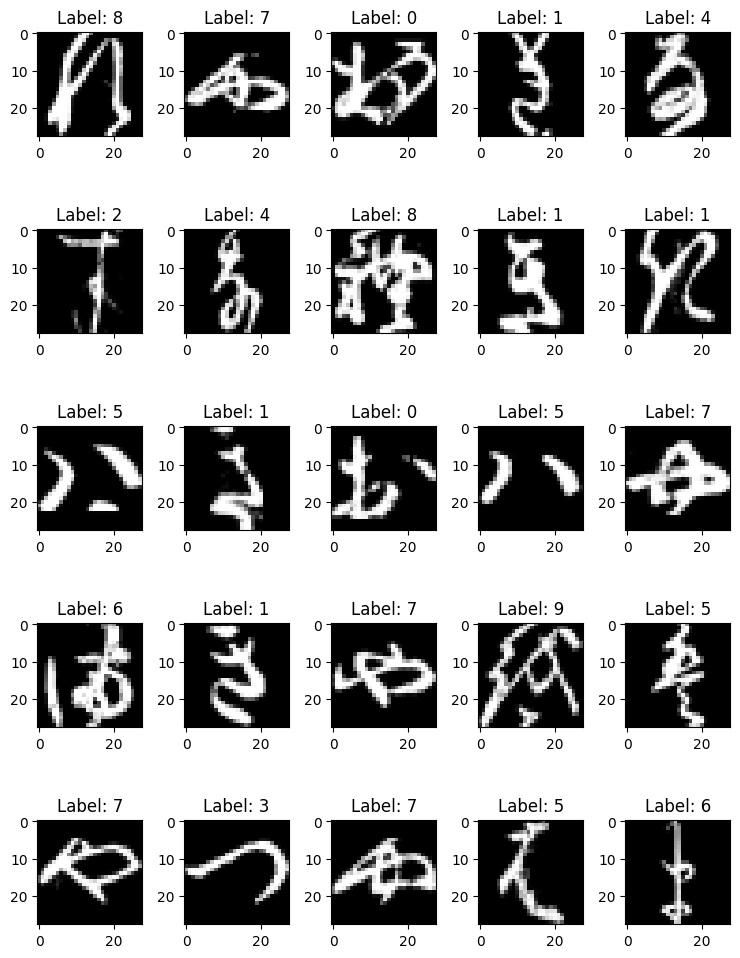

In [83]:
num_row = 5
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [84]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## Definisco il primo modello, una rete neurale convoluzionale

In [85]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.l1 = nn.Linear(10 * 26 * 26, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = torch.flatten(x, start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        logits = self.l2(x)

        return logits

In [86]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Rich mac user
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    return losses, accs, norms

In [87]:
model = MyModel()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

_, _, W_adam = train_model(model, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.4103 | Train Accuracy: 87.7201 | Time: 7.68
Epoch: 2 | Loss: 0.1590 | Train Accuracy: 95.3892 | Time: 8.33
Epoch: 3 | Loss: 0.0988 | Train Accuracy: 97.1935 | Time: 7.10
Epoch: 4 | Loss: 0.0648 | Train Accuracy: 98.2307 | Time: 7.61
Epoch: 5 | Loss: 0.0403 | Train Accuracy: 98.9661 | Time: 7.14
Epoch: 6 | Loss: 0.0256 | Train Accuracy: 99.3697 | Time: 7.57
Epoch: 7 | Loss: 0.0185 | Train Accuracy: 99.5414 | Time: 7.63
Epoch: 8 | Loss: 0.0128 | Train Accuracy: 99.7148 | Time: 7.07
Epoch: 9 | Loss: 0.0088 | Train Accuracy: 99.8899 | Time: 7.72
Epoch: 10 | Loss: 0.0108 | Train Accuracy: 99.7715 | Time: 7.61


In [88]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 92.0373


In [89]:
torch.save(model.state_dict(), 'Hiragana.pth')

## Nuovo test

In [58]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.l1 = nn.Linear(10 * 24 * 24, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = torch.flatten(x, start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        logits = self.l2(x)

        return logits

In [59]:
model2 = MyModel2()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

_, _, W_adam = train_model(model2, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 2.3050 | Train Accuracy: 12.0531 | Time: 8.37
Epoch: 2 | Loss: 2.3050 | Train Accuracy: 12.0531 | Time: 8.90
Epoch: 3 | Loss: 2.3050 | Train Accuracy: 12.0531 | Time: 8.96
Epoch: 4 | Loss: 2.3050 | Train Accuracy: 12.0531 | Time: 8.64


KeyboardInterrupt: 

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 90.8153


In [54]:
torch.save(model.state_dict(), 'Hiragana_kernel5.pth')

## Nuovo Modello

In [79]:
class MyModel3(nn.Module):
    def __init__(self):
        super(MyModel3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.l1 = nn.Linear(10 * 13 * 13, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        x = self.pool(x)

        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = torch.flatten(x, start_dim = 1)

        # BSx(32*26*26) => BSx128
        logits = self.l1(x)

        return logits

In [80]:
model3 = MyModel3()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

_, _, W_adam = train_model(model3, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 2.3288 | Train Accuracy: 10.0070 | Time: 8.28
Epoch: 2 | Loss: 2.3288 | Train Accuracy: 10.0070 | Time: 8.65


KeyboardInterrupt: 